#Modelo predictivo de diagnosticos de cancer de mama.
###Dataset utilizado: "Breast Cancer Dataset" de la plataforma Kaggle (uso plublico).
###Algoritmo de clasificación: Support Vector Machine (SVM).
###Tecnicas de inteligencia artificial explicativa (XAI): SHAP y LIME.

###Instalación de librerias necesarias para el uso de XAI

In [1]:
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4065f8fd5ca47a6215b1bc51a63693be5225fefa691b2d7fee404884aafa125d
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


###Importación de las librerias necesarias para el modelo.

In [3]:
import os
import kagglehub

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shap
shap.initjs()

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import loguniform, randint
from lime.lime_tabular import LimeTabularExplainer

###Exportación del dataset

In [4]:
#Se guarda la ruta de acceso al dataset.
file_path = '/content/drive/MyDrive/breast-cancer.csv'

#Se lee y guarda el dataset dentro de la variable 'df'.
df = pd.read_csv(file_path)

###Preprocesado de los datos.

In [5]:
#Se crea la variable 'le' para luego usarla para convertir datos categoricos a numericos.
le = LabelEncoder()

#Se elimina la columna 'id' ya que no es relevante para la predicción.
df.drop(["id"], axis=1, inplace=True)

#Se selecciona la columna de 'diagnosis' para convertir sus datos de categoricos a numericos.
df["diagnosis"] = le.fit_transform(df["diagnosis"])

#Se imprimen los datos para confirmar los cambios.
print(df.head())

#Se imprime la cantidad de filas y columnas dentro del dataset luego de los cambios.
df.shape

   diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          

(569, 31)

###Busqueda de datos nulos.

In [6]:
#Se busca si existen datos nulos dentro de las columnas.
df.isnull().sum()

,0
diagnosis,0
radius_mean,0
texture_mean,0
perimeter_mean,0
area_mean,0
smoothness_mean,0
compactness_mean,0
concavity_mean,0
concave points_mean,0
symmetry_mean,0


###Visualización del contenido de 'diagnosis'.

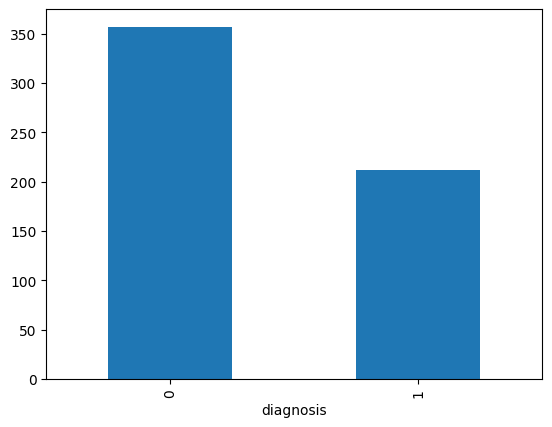

,count
diagnosis,
0,357
1,212


In [7]:
#Se guarda la columna 'diagnosis' como objetivo
target = df["diagnosis"]

#Se guardan los datos de la columna.
data = target.value_counts()

#Se genera un grafico de barra para visualizar la cantidad de casos de cancer maligno (1) y benigno (0)
data.plot(kind='bar')
plt.show()

#Entrega el numero de datos correspondiente a cada valor de la columna.
target.value_counts()

###Correlación entre las caracteristicas y 'diagnosis'.

In [8]:
#Se guarda la correlación existente entre las variables y 'diagnosis'.
corr = df.corr()['diagnosis'].sort_values(ascending=False)

#Se imprime la correlación de las variables en orden descendente.
print(corr)

diagnosis                  1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
symmetry_se               -0

###Visualización de la correlación de las caracteristicas.

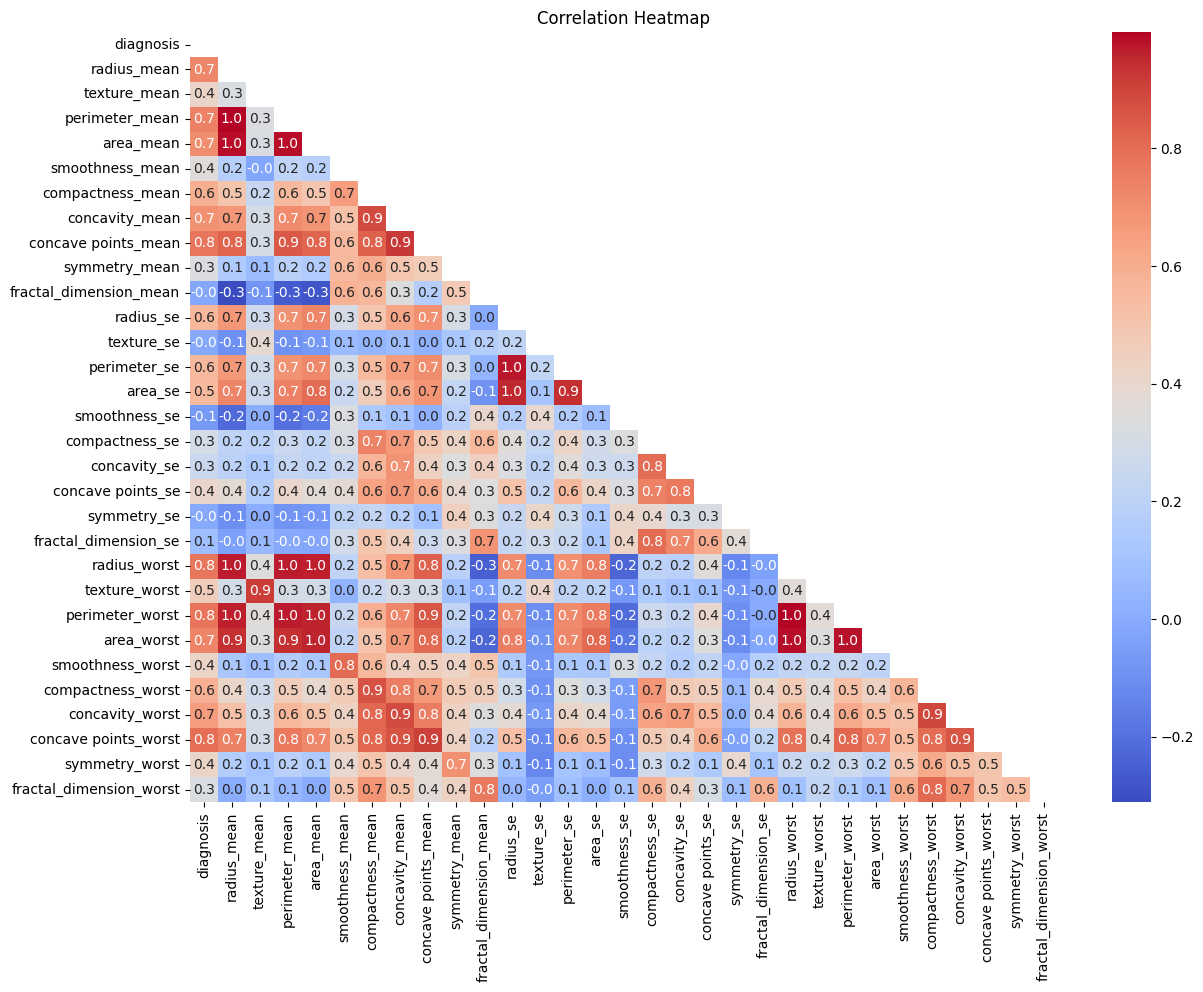

In [9]:
#Se establecen los atributos del grafico (heatmap) de correlación.
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.1f', cbar=True, mask=np.triu(np.ones_like(df.corr(), dtype=bool)))
plt.title("Correlation Heatmap")
plt.show()

###Descarte de caracteristicas con alta correlación.

In [10]:
#Se calcula la matriz de correlación
corr_matrix = df.corr().abs()

#Se aplica una mascara para seleccionar solo el triangulo superior de la matriz de correlación.
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

#Se buscan las caracteristicas con una correlación mayor a 0.8 .
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

#Se descartan las caracteristicas con una alta correlación.
df_reduced = df.drop(columns=to_drop)

#Se imprime tanto el dataframe original como el nuevo.
print("DataFrame original:")
print(df.shape)
print("\nDataFrame tras descartar las caracteristicas con alta correlación:")
print(df_reduced.shape)

DataFrame original:
(569, 31)

DataFrame tras descartar las caracteristicas con alta correlación:
(569, 21)


###Preparación de los datos de entrenamiento y prueba.

In [11]:
#Se selecciona la columna 'diagnosis' del dataframe recortado para el valor y.
y = df_reduced["diagnosis"]

#Se seleccionan todas las demas caracteristicas salvo 'diagnosis'.
X = df_reduced.drop(["diagnosis"], axis=1)

#Se establecen los datos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Se crea la variable 'scaler' para luego usarla para normalizar las caracteristicas.
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Se imprimen los datos y columnas de entrenamiento y prueba.
print("x_train shape: ", X_train.shape)
print("x_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (455, 20)
x_test shape:  (114, 20)
y_train shape:  (455,)
y_test shape:  (114,)


###Construcción del modelo y busqueda de sus hiperparametros.

In [12]:
#Definimos el modelo base.
svm = SVC(probability=True)

#Definir la grilla de hiperparámetros.
param_dist = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [1e-4, 1e-3, 1e-2, 1e-1],
    'kernel': ['rbf', 'poly']
}

# Búsqueda con validación cruzada
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_dist,
    scoring='roc_auc',
    cv=10,
    verbose=2,
    n_jobs=-1
)

#Ejecutamos la búsqueda.
grid_search.fit(X_train, y_train)

#Se imprimen los mejores parametros encontrados por el GridSearchCV
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

#Se guarda el mejor modelo.
best_model = grid_search.best_estimator_

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Mejores hiperparámetros:
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


###Precision de las predicciones del modelo

In [13]:
#Se realizan predicciones sobre el conjunto de prueba (X_test) usando el mejor modelo.
y_pred = best_model.predict(X_test)

#Se imprime la precisión del modelo y el reporte.
print("Accuracy en el conjunto de prueba:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy en el conjunto de prueba: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



###Matriz de confusión del modelo.

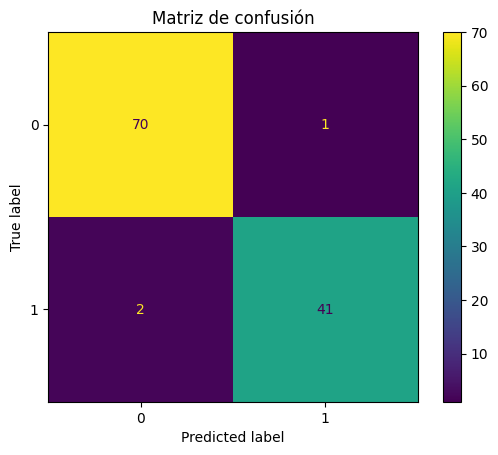

In [14]:
# Matriz de confusión
labels = np.unique(y)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title("Matriz de confusión")
plt.show()

###Visualización del area bajo la curva del modelo.

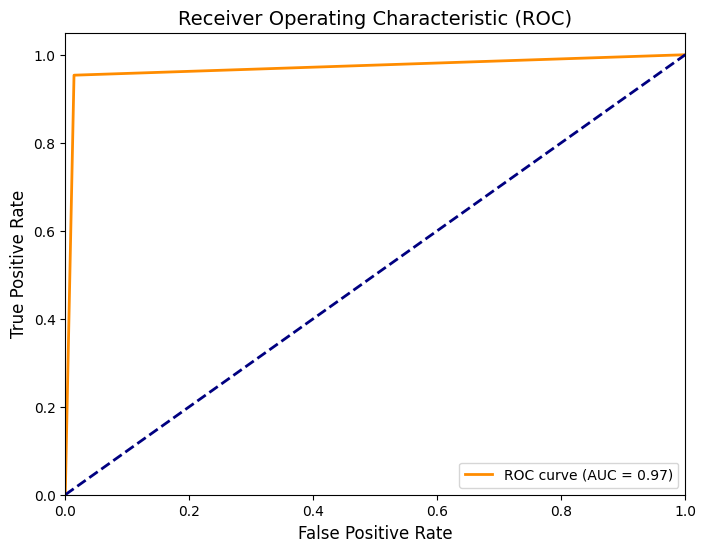

In [15]:
#Se grafica el area bajo la curva del modelo.
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Receiver Operating Characteristic (ROC)", fontsize=14)
plt.legend(loc="lower right")
plt.show()

###Sensibilidad y especificidad del modelo.

In [16]:
#Calcular sensibilidad y especificidad desde la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

sensibilidad = tp / (tp + fn)
especificidad = tn / (tn + fp)

#Se Imprimen la sensibilidad y especificidad
print(f"Sensibilidad (Recall): {sensibilidad:.2f}")
print(f"Especificidad: {especificidad:.2f}")

Sensibilidad (Recall): 0.95
Especificidad: 0.99


###Explicador y valores SHAP.

In [17]:
#Se crea un 'explicador' utilizando el 'shap.KernelExplainer()' con el mejor modelo.
explainer = shap.KernelExplainer(best_model.predict_proba, X_train)

#Se calculan los valores SHAP del conjunto de prueba.
shap_values = explainer.shap_values(X_test)

  0%|          | 0/114 [00:00<?, ?it/s]

###Grafico general de valores SHAP (caso Maligno).

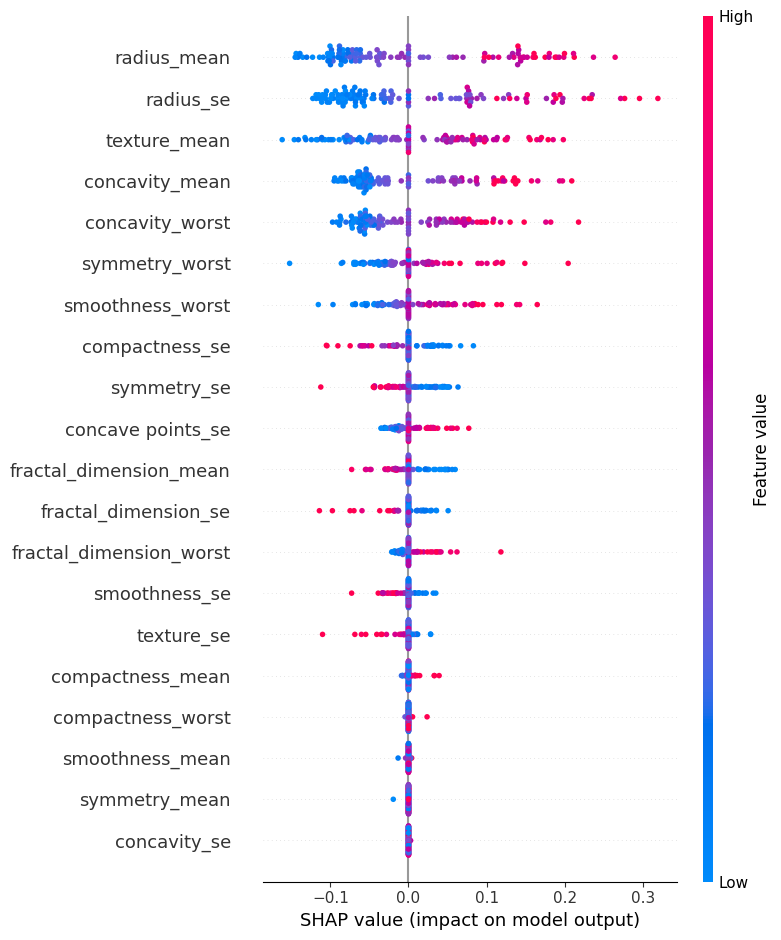

In [18]:
#Se realiza una grafica general de los valores SHAP para el caso de que sea 1 (Maligno).
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=X.columns)

###Grafico general de valores SHAP (caso Benigno).

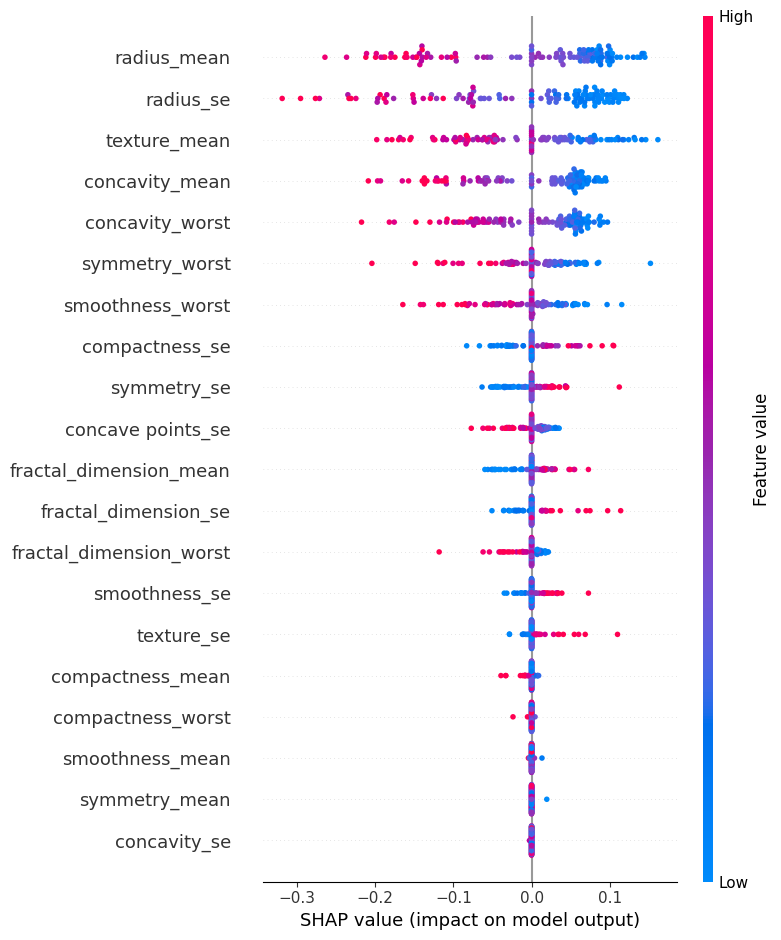

In [19]:
#Se realiza una grafica general de los valores SHAP para el caso de que sea 0 (Benigno).
shap.summary_plot(shap_values[:, :, 0], X_test, feature_names=X.columns)

###Grafico de dependencia entre 'radius_se' y 'radius_mean' para caso Maligno.

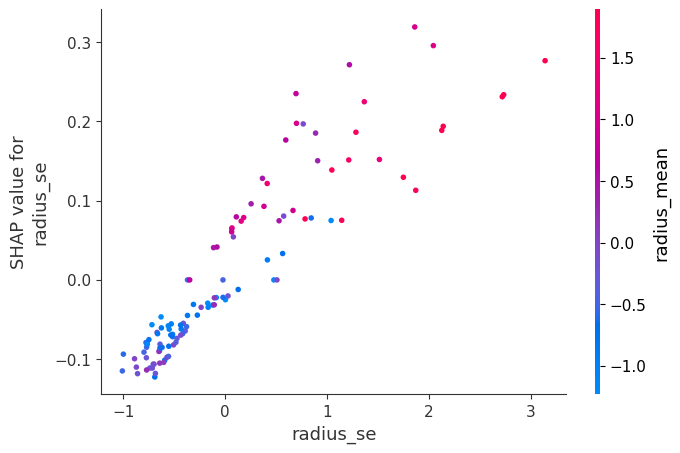

In [20]:
#Se genera una grafica de dependencia entre la caracteristica 'radius_se' y 'radius_mean' para caso Maligno.
shap.dependence_plot("radius_se", shap_values[:, :, 1], X_test, interaction_index="radius_mean", feature_names=X.columns)

###Grafico de dependencia entre 'radius_se' y 'radius_mean' para caso Benigno.

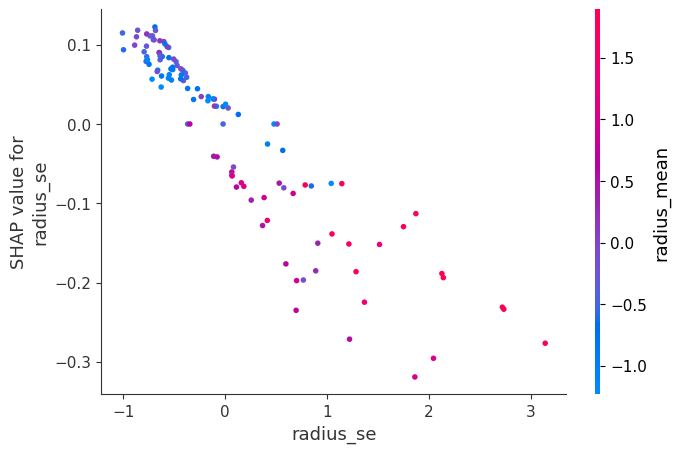

In [21]:
#Se genera una grafica de dependencia entre la caracteristica 'radius_se' y 'radius_mean' para caso Benigno.
shap.dependence_plot("radius_se", shap_values[:, :, 0], X_test, interaction_index="radius_mean", feature_names=X.columns)

###Grafico de dependencia entre 'texture_mean' y 'radius_mean' para caso Maligno.

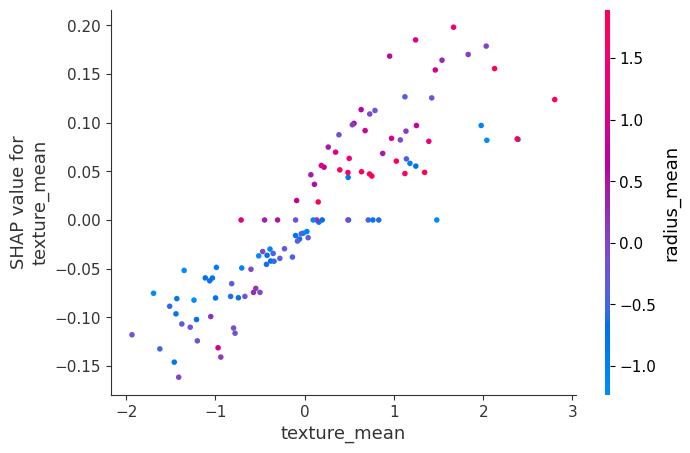

In [22]:
shap.dependence_plot("texture_mean", shap_values[:, :, 1], X_test, interaction_index="radius_mean", feature_names=X.columns)

###Grafico de dependencia entre 'texture_mean' y 'radius_mean' para caso Benigno.

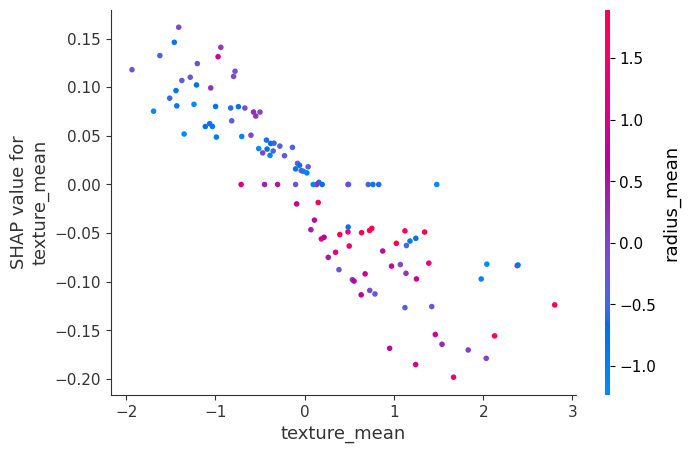

In [23]:
shap.dependence_plot("texture_mean", shap_values[:, :, 0], X_test, interaction_index="radius_mean", feature_names=X.columns)

###Grafico de dependencia entre 'concavity_mean' y 'radius_mean' para caso Maligno.

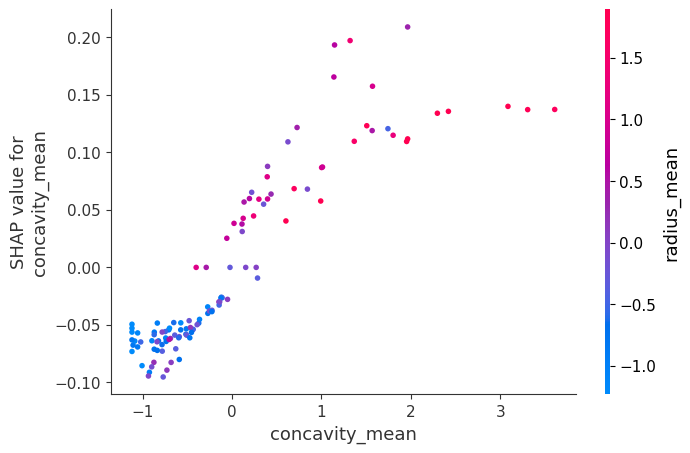

In [24]:
shap.dependence_plot("concavity_mean", shap_values[:, :, 1], X_test, interaction_index="radius_mean", feature_names=X.columns)

###Grafico de dependencia entre 'concavity_mean' y 'radius_mean' para caso Benigno.

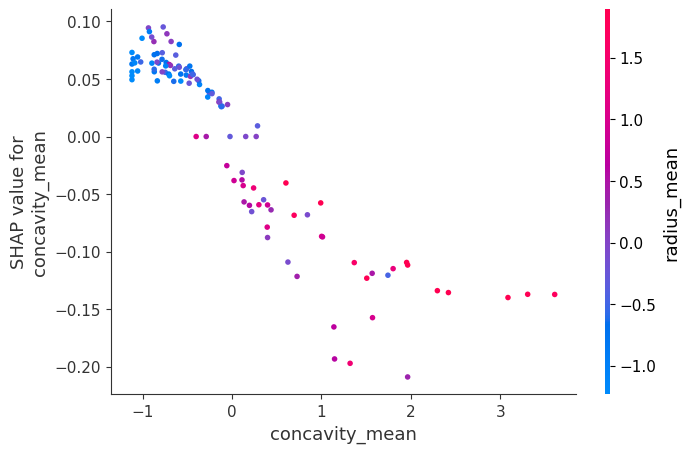

In [25]:
shap.dependence_plot("concavity_mean", shap_values[:, :, 0], X_test, interaction_index="radius_mean", feature_names=X.columns)

###Grafico de dependencia entre 'concavity_worst' y 'radius_mean' para caso Maligno.

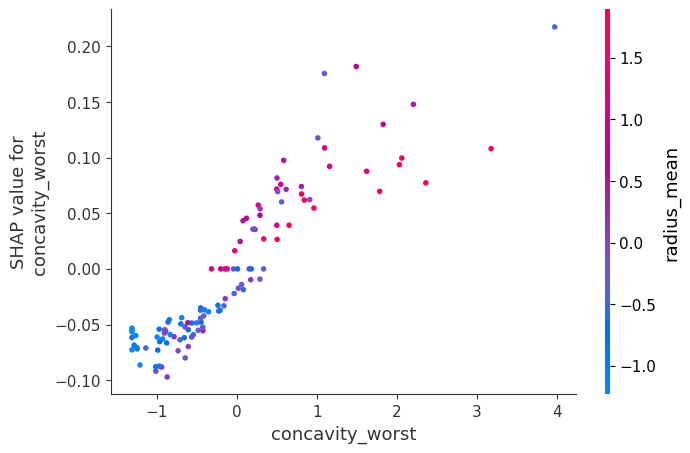

In [26]:
shap.dependence_plot("concavity_worst", shap_values[:, :, 1], X_test, interaction_index="radius_mean", feature_names=X.columns)

###Grafico de dependencia entre 'concavity_worst' y 'radius_mean' para caso Benigno.

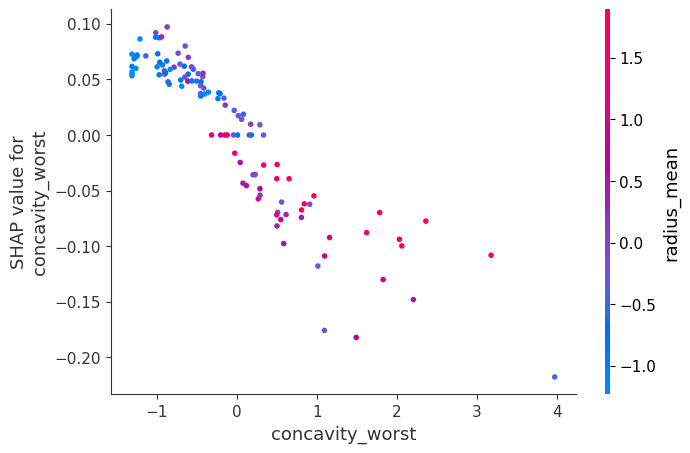

In [27]:
shap.dependence_plot("concavity_worst", shap_values[:, :, 0], X_test, interaction_index="radius_mean", feature_names=X.columns)

###Grafico de dependencia entre 'compactness_se' y 'radius_mean' para caso Maligno.

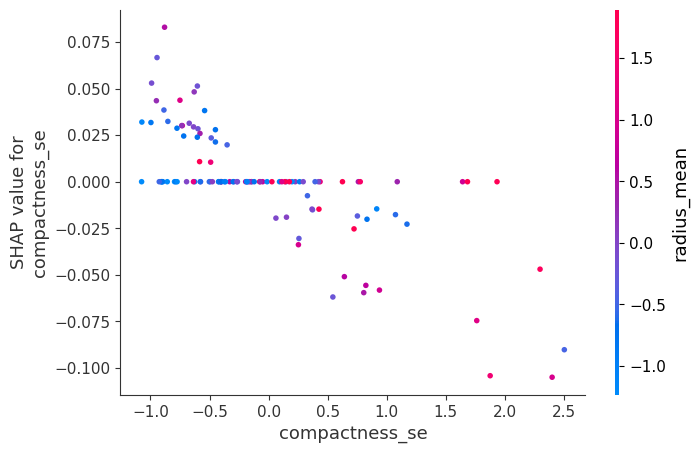

In [28]:
shap.dependence_plot("compactness_se", shap_values[:, :, 1], X_test, interaction_index="radius_mean", feature_names=X.columns)

###Grafico de dependencia entre 'compactness_se' y 'radius_mean' para caso Benigno.

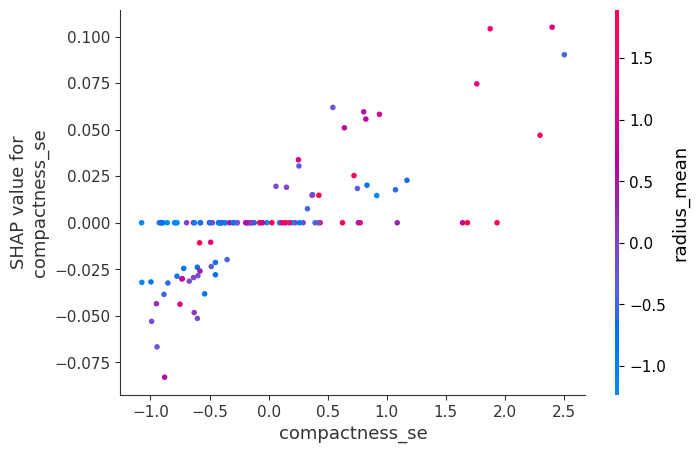

In [29]:
shap.dependence_plot("compactness_se", shap_values[:, :, 0], X_test, interaction_index="radius_mean", feature_names=X.columns)

###Grafico de fuerza del caso 11 (Maligno).

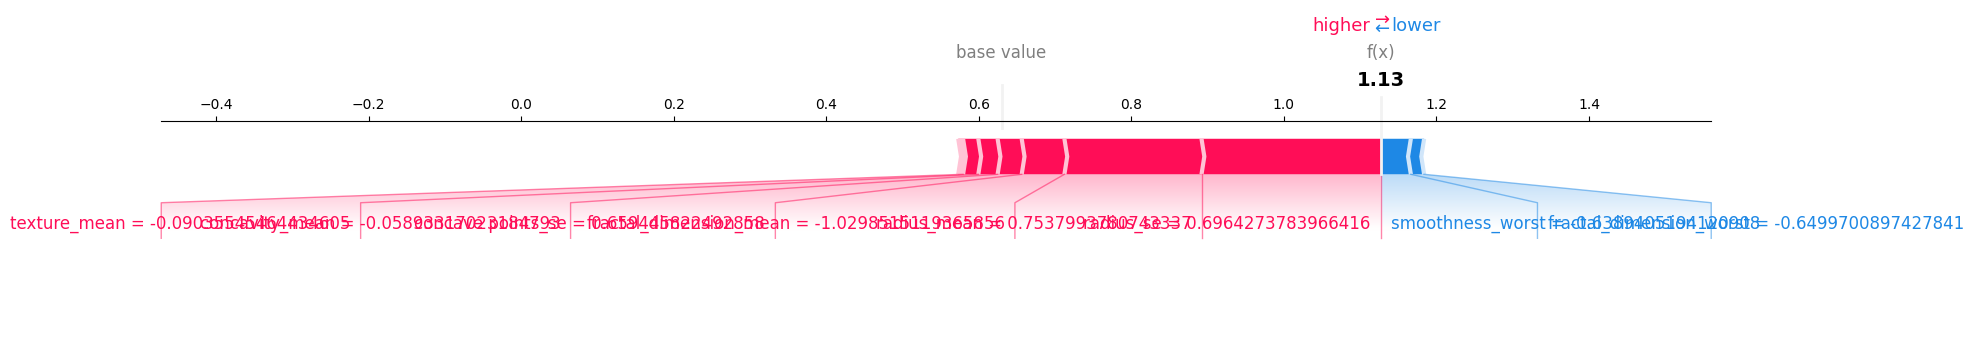

In [30]:
#Se realiza un grafico de fuerza en relación con el caso 11 (caso Maligno).
shap.plots.force(explainer.expected_value[0], shap_values[11,:, 1], X_test[11, :], matplotlib = True, feature_names=X.columns )

###Grafico de fuerza del caso 14 (Benigno).

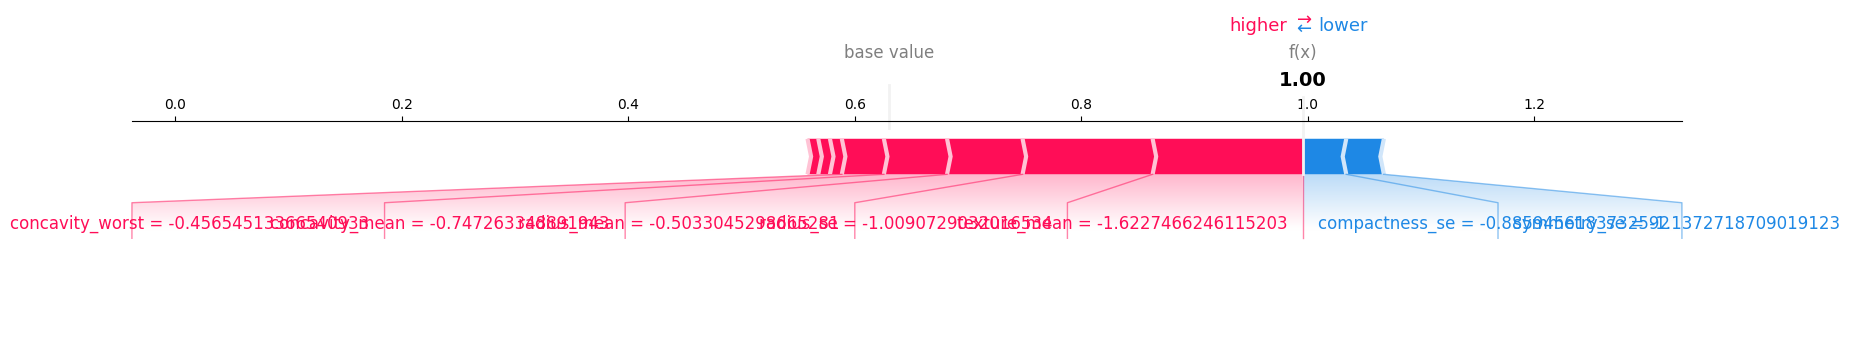

In [31]:
#Se realiza un grafico de fuerza en relación con el caso 14 (caso Benigno).
shap.plots.force(explainer.expected_value[0], shap_values[14,:, 0], X_test[14, :], matplotlib = True, feature_names=X.columns )

###Grafico de decisiones del caso 11 (Maligno).

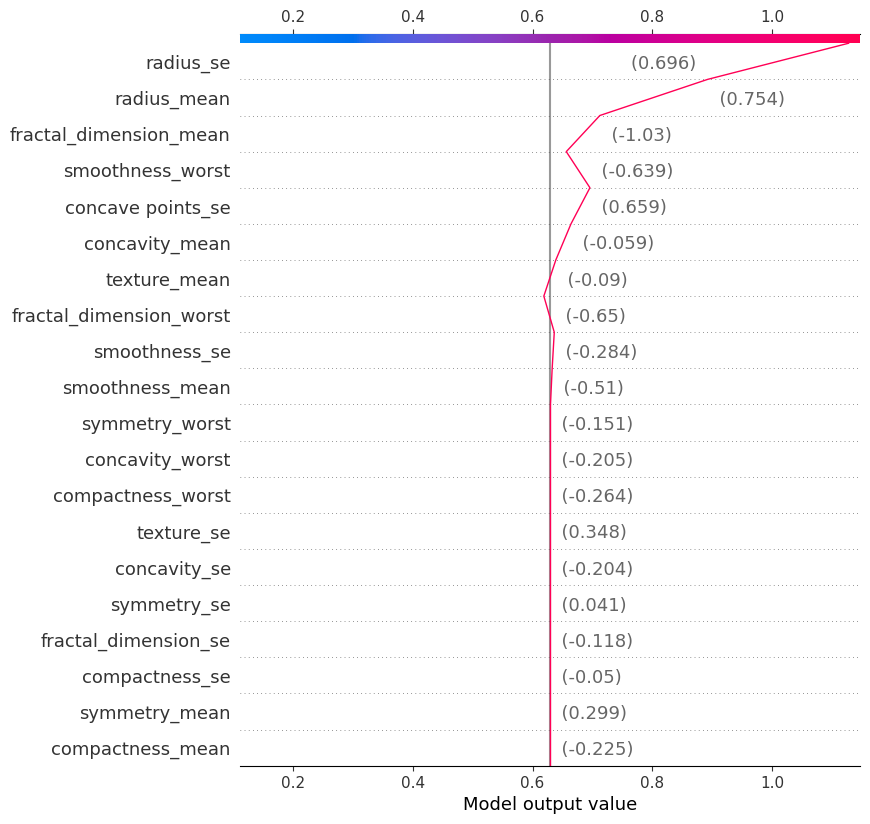

In [32]:
#Se realiza un grafico de decisiones del caso 11 (Caso Maligno).
shap.decision_plot(explainer.expected_value[0], shap_values[11,:, 1], X_test[11, :], X.columns.tolist())

###Grafico de decisiones del caso 14 (Benigno).

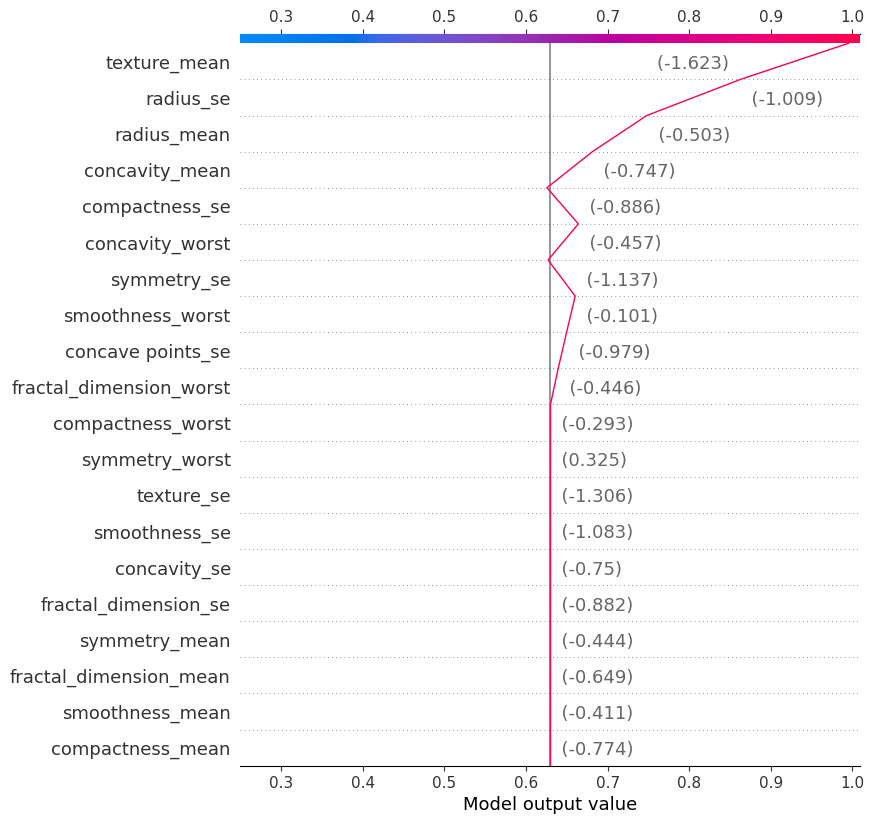

In [33]:
#Se realiza un grafico de decisiones del caso 14 (Caso benigno).
shap.decision_plot(explainer.expected_value[0], shap_values[14,:, 0], X_test[14, :], X.columns.tolist())

###Grafico LIME de influencia a nivel local.

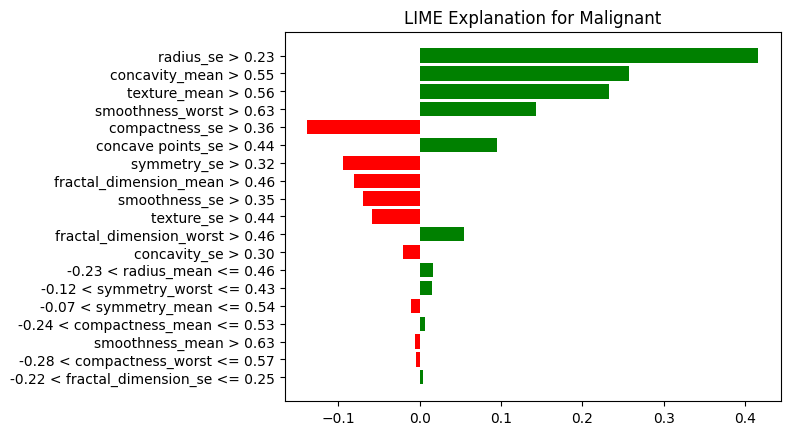

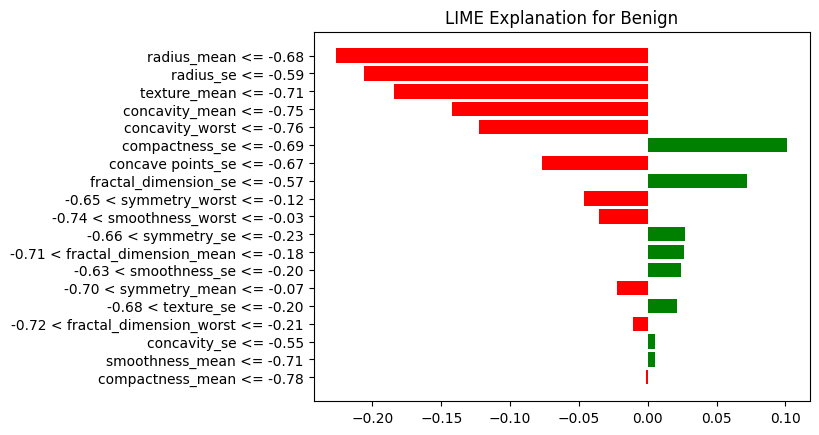

In [34]:
#Se definen los nombres de las clases según el problema de clasificación (por ejemplo, cáncer benigno o maligno)
class_names = ['Benigno', 'Maligno']

#Se obtiene la lista de nombres de características a partir del conjunto de entrenamiento
feature_names = list(X.columns)

#Se crea el explicador LIME configurado para problemas de clasificación tabular.
#Este explicador utilizará las instancias de entrenamiento para generar explicaciones locales.
explainer = LimeTabularExplainer(X_train,
                                 feature_names=feature_names,
                                 class_names=class_names,
                                 mode='classification')

#Identificación de índices en el conjunto de prueba para cada clase
#Aquí se asume que el valor 1 representa la clase "Maligno" y 0 la clase "Benigno"
malignant_indices = y_test[y_test == 1].index
benign_indices = y_test[y_test == 0].index

# === Explicación de una instancia de la clase "Maligno" ===

#Se filtran los índices para asegurarse de que estén dentro del rango válido de X_test
valid_malignant_indices = malignant_indices[malignant_indices < len(X_test)]

#Se selecciona la primera instancia válida de la clase "Maligno"
i_malignant = valid_malignant_indices[0]

#Se genera una explicación local usando LIME para la instancia seleccionada
#'num_features=19' indica cuántas características incluir en la explicación
exp_malignant = explainer.explain_instance(X_test[i_malignant],
                                           best_model.predict_proba,
                                           num_features=19)

#Visualización de la explicación para la instancia maligna
exp_malignant.as_pyplot_figure()
plt.title('LIME Explanation for Malignant')
plt.show()

# === Explicación de una instancia de la clase "Benigno" ===

#Se filtran los índices para asegurarse de que estén dentro del rango válido de X_test
valid_benign_indices = benign_indices[benign_indices < len(X_test)]

#Se selecciona la primera instancia válida de la clase "Benigno"
i_benign = valid_benign_indices[0]

#Se genera una explicación local usando LIME para la instancia seleccionada
exp_benign = explainer.explain_instance(X_test[i_benign],
                                        best_model.predict_proba,
                                        num_features=19)

#Visualización de la explicación para la instancia benigna
exp_benign.as_pyplot_figure()
plt.title('LIME Explanation for Benign')
plt.show()